In [1]:
from improved import preprocess_and_split_data, align_forecast_to_indices
import numpy as np

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("model_final.pth", map_location=device)


C:\Users\janav\AppData\Local\Temp\ipykernel_5260\3368243719.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model_final.pth", map_location=device)


In [5]:
import joblib
import numpy as np
import torch

def run_autoregressive_forecast(model, csv_path, encoder_seq_length, decoder_seq_length, scaler_dir='scalers', device='cpu'):
    # Load data and scalers
    train_loader, val_loader, test_loader, test_target_indices, full_df = preprocess_and_split_data(
        csv_path, encoder_seq_length, decoder_seq_length
    )

    scaler_target = joblib.load(f"{scaler_dir}/scaler_target.pkl")
    scaler_day = joblib.load(f"{scaler_dir}/scaler_day.pkl")
    scaler_context = joblib.load(f"{scaler_dir}/scaler_context.pkl")
    pca = joblib.load(f"{scaler_dir}/pca.pkl")

    # Extract last validation batch for initial input
    val_batch = list(val_loader)[-1]
    last_enc_input = val_batch[0][-1].unsqueeze(0).to(device)  # shape: [1, enc_len, input_dim]
    last_dec_input = val_batch[1][-1].unsqueeze(0).to(device)  # shape: [1, dec_len, 1]

    # Prepare test data
    test_df = full_df.iloc[test_target_indices[0][0] - decoder_seq_length:].copy().reset_index(drop=True)
    total_forecast_steps = len(test_target_indices)
    all_preds = []

    # Pre-scale day_of_week and context once
    scaled_day = scaler_day.transform(test_df[['day_of_week']])
    raw_context = test_df[['SMA_7', 'day_of_week', 'month']].astype(float)
    scaled_context = pca.transform(scaler_context.transform(raw_context))
    sma7 = test_df[['SMA_7']].values
    input_full = np.concatenate([sma7, scaled_day, scaled_context], axis=1)

    for step in range(total_forecast_steps):
        # Predict next window
        with torch.no_grad():
            pred = model(last_enc_input, last_dec_input)  # shape: [1, decoder_len, 1]

        pred_np = pred.cpu().numpy().reshape(-1)  # shape: (decoder_len,)
        all_preds.append(pred_np)  # collect as windows

        # Inject first predicted value into test_df['SMA_7']
        test_df.loc[encoder_seq_length + step, 'SMA_7'] = pred_np[0]
        sma7[encoder_seq_length + step] = pred_np[0]  # update underlying array

        # Rebuild encoder input from updated SMA_7 + previously scaled day/context
        input_full = np.concatenate([sma7, scaled_day, scaled_context], axis=1)
        next_enc_input = input_full[step:step + encoder_seq_length]
        next_dec_input = np.array(pred_np).reshape(1, decoder_seq_length, 1)

        last_enc_input = torch.tensor(next_enc_input, dtype=torch.float32).unsqueeze(0).to(device)
        last_dec_input = torch.tensor(next_dec_input, dtype=torch.float32).to(device)

    # Inverse scale and align
    all_preds = np.array(all_preds).reshape(-1, decoder_seq_length)
    y_pred = scaler_target.inverse_transform(all_preds.reshape(-1, 1)).reshape(all_preds.shape)
    pred_series = align_forecast_to_indices(y_pred, test_target_indices, len(full_df))

    # Align with test portion of original series
    test_start = int(len(full_df) * 0.7)
    y_true = full_df['SMA_7'].values[test_start:]
    pred_series = pred_series[test_start:]

    return pred_series, y_true


In [6]:
lookback = 24
horizon = 24
pred, y_true = run_autoregressive_forecast(model, 'mm79158.csv', lookback, horizon, device=device)

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mse = mean_squared_error(y_true, pred)
mae = mean_absolute_error(y_true, pred)
mape = mean_absolute_percentage_error(y_true, pred)

print(f'MSE: {mse}, MAE: {mae}, MAPE: {mape}')

MSE: 162.03802106099644, MAE: 11.733703063182126, MAPE: 2.6378648694634923


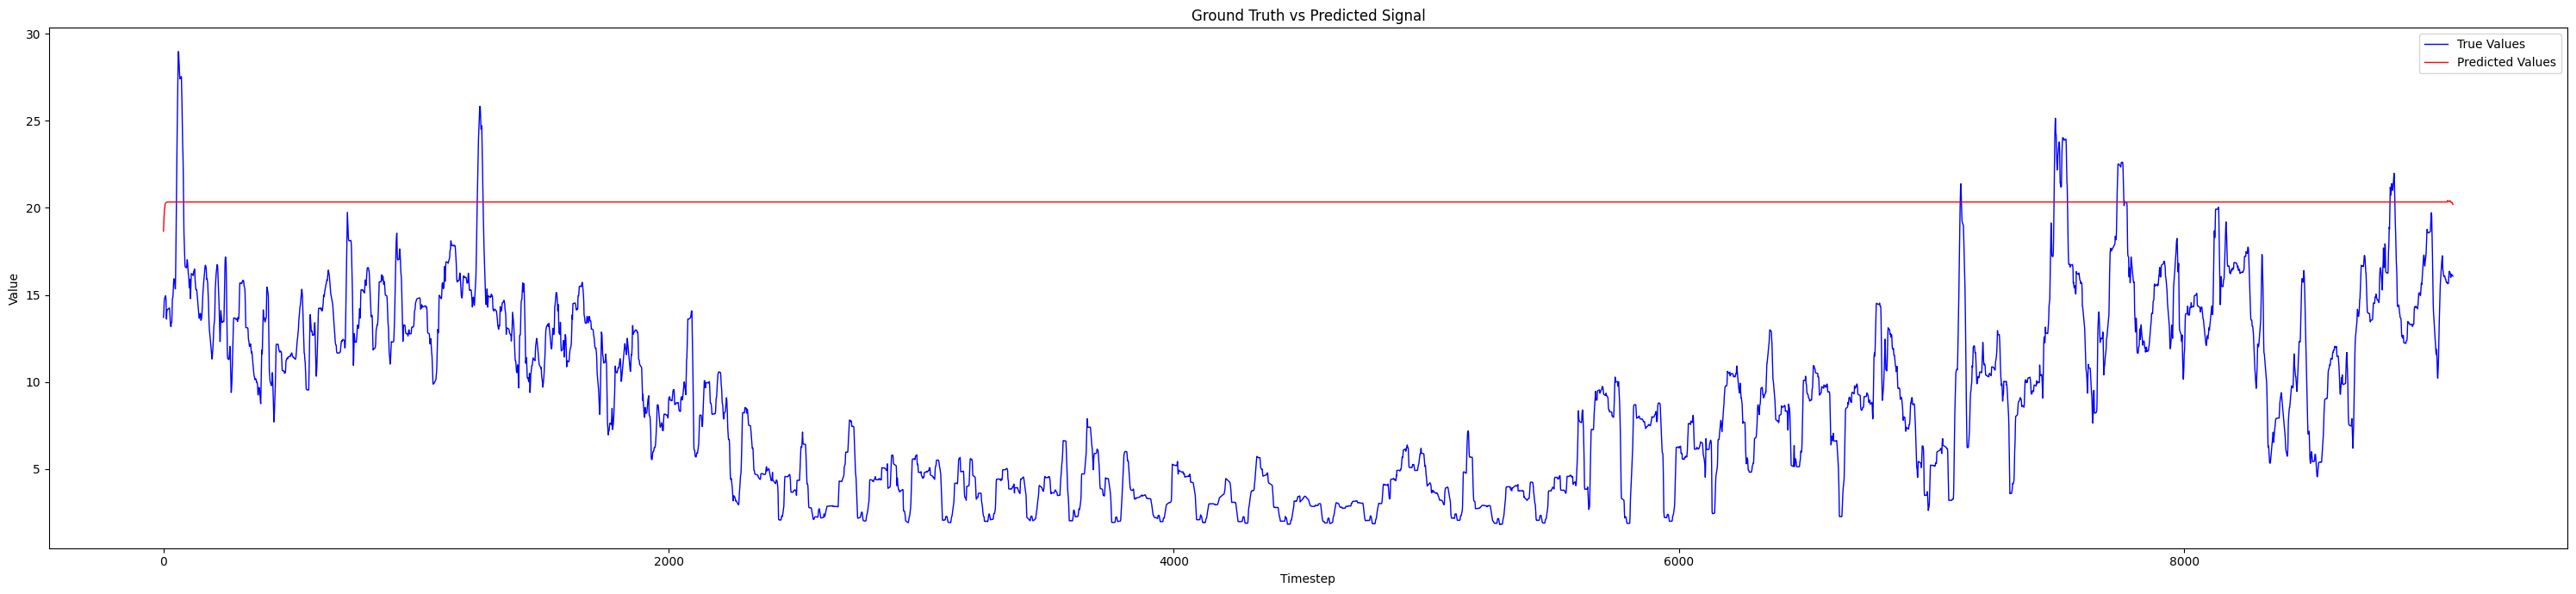

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 7))
plt.plot(y_true, label="True Values", color="blue", linewidth=1)
plt.plot(pred, label="Predicted Values", color="red", linewidth=1)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title("Ground Truth vs Predicted Signal")
plt.legend()
plt.tight_layout()
plt.savefig("plot/true_vs_predicted.png", dpi=300, bbox_inches='tight')

In [9]:
import pandas as pd
pd.DataFrame({'pred': pred, 'y_true': y_true}).describe()

,pred,y_true
count,9065.000000,9065.000000
mean,20.337520,8.705991
std,0.025850,5.171190
min,18.661980,1.803333
25%,20.338129,4.068333
50%,20.338129,8.146250
75%,20.338131,12.785833
max,20.421421,28.987083
